In [41]:
import os
import numpy as np
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import re
from IPython.display import HTML

mpl.rcParams['figure.dpi'] = 300

In [42]:
def read_spectrum(path, samples=None, times=None):
    files = os.listdir(path)
    reg = re.compile(r'^energy_\d+_time_\d+.txt$')
    spectrum_files = list(filter(reg.search, files))
    if samples is None:
        samples = list(set(list(sorted([int(f.split('_')[1])for f in spectrum_files]))))
    if times is None:
        times = list(set(list(sorted([int(f[:-4].split('_')[3]) for f in spectrum_files]))))
    spectra = []
    for t in times:
        spectrum = []
        for s in samples:
            with open(os.path.join(path, f'energy_{s}_time_{t}.txt'), 'r') as f:
                spectrum.append([float(v) for v in f.read().split()])
        spectra.append(np.array(spectrum))
    return spectra

def compensate_spectrum(spectra, gamma):
    compensated_spectra = []
    for spectrum in spectra:
        K = np.array([[2*np.pi*i for i in range(spectrum.shape[1])]])
        compensated_spectra.append(K**gamma * spectrum)
    return compensated_spectra

def spectrum_mean(spectra):
    means = [np.mean(spectrum, 0) for spectrum in spectra]
    return means

def spectrum_variance(spectra):
    variances = [np.var(spectrum, 0) for spectrum in spectra]
    return variances

def spectrum_quantiles(spectra, q):
    quantiles = [np.quantile(spectrum, q, 0) for spectrum in spectra]
    return quantiles

In [43]:
def plot_spectrum(paths, Ns, time, gamma, samples=None):
    for i,(path,N) in enumerate(zip(paths, Ns)):
        spectra = read_spectrum(path, samples, times=[time])
        spectra = compensate_spectrum(spectra, gamma)
        mean = spectrum_mean(spectra)[0]
        #mean /= mean[1]
        K = [2*np.pi*k for k in range(len(mean))]
        plt.loglog(K, mean, color=f'C{i}', label=f'N={N}')
    plt.loglog(K, [1]*len(K), '--', color='grey', label='$K^{-\\gamma}$')
    plt.xlabel('$K$')
    plt.ylabel(r'$K^{\gamma}E(K)$')
    plt.legend()
    plt.title(f'Compensated Energy Spectrum for $\\gamma={gamma:.3}$')
    plt.show()
    
def animate_spectrum(paths, Ns, gamma, times=None, samples=None):
    spectra = [read_spectrum(path, samples, times) for path in paths]
    spectra = [compensate_spectrum(spectrum, gamma) for spectrum in spectra]
    means = [spectrum_mean(spectrum) for spectrum in spectra]
    means = [[m/m[1] for m in mean] for mean in means]
    max_mean = max([max([max([max(t[1:]) for t in m]) for m in means]) for mean in means])
    min_mean = min([min([min([min(t[1:]) for t in m]) for m in means]) for mean in means])
    K = [[2*np.pi*k for k in range(len(mean[0]))] for mean in means]
    fig, ax = plt.subplots()
    lines = []
    for N in Ns:
        lines.append(plt.loglog([], label=f'N={N}')[0])
    plt.loglog(K[-1], [1]*len(K[-1]), '--', color='grey', label='$K^{-\\gamma}$')
    ax.set_xlim(K[0][1], K[-1][-1])
    ax.set_ylim(min_mean, max_mean)
    plt.legend()
    def animate(frame):
        for i,line in enumerate(lines):
            line.set_data((K[i], means[i][frame]))
        return lines
    anim = FuncAnimation(fig, animate, frames=len(means[0]), interval=20)
    HTML(anim.to_html5_video())

In [44]:
def energy(spectra):
    energies = [np.sum(spectrum, 1) for spectrum in spectra]
    return energies

def energy_mean(energies):
    means = [e.mean() for e in energies]
    return means

def energy_dissipation(energies, dt):
    diss = [(energies[i+1]-energies[i])/dt for i in range(len(energies)-1)]
    return diss
    
def relative_energy_dissipation(energies, dt):
    diss = energy_dissipation(energies, dt)
    rel_diss = [de/energies[0] for de in diss]
    return rel_diss

In [45]:
def plot_energy(paths, Ns, dt, samples=None, times=None):
    for i,(path,N) in enumerate(zip(paths, Ns)):
        spectra = read_spectrum(path, samples, times)
        energies = energy(spectra)
        E = [e.mean() for e in energies]
        plt.plot(np.linspace(0, len(E)*dt, len(E)), E, color=f'C{i}', label=f'N={N}')
    plt.xlabel('t')
    plt.ylabel('E(t)')
    plt.title('Total Energy over Time')
    plt.legend()
    plt.show()
    
def plot_relative_energy_dissipation(paths, Ns, dt, samples=None, times=None):
    for i,(path,N) in enumerate(zip(paths, Ns)):
        spectra = read_spectrum(path, samples, times)
        energies = energy(spectra)
        rel_diss = [e.mean() for e in relative_energy_dissipation(energies, dt)]
        plt.plot(np.linspace(0, len(rel_diss)*dt, len(rel_diss)), [-d for d in rel_diss], color=f'C{i}', label=f'N={N}')
    plt.xlabel('t')
    plt.ylabel(r'$-\Delta E(t) / E_0$')
    plt.title('Relative Energy Dissipation over Time')
    plt.legend()
    plt.show()

# Energy Spectra of Brownian Bridges

In [46]:
os.environ['AZEBAN_EXPERIMENT_DIR'] = '~/Programmieren/azeban/build'
experiment_folder = os.environ['AZEBAN_EXPERIMENT_DIR']

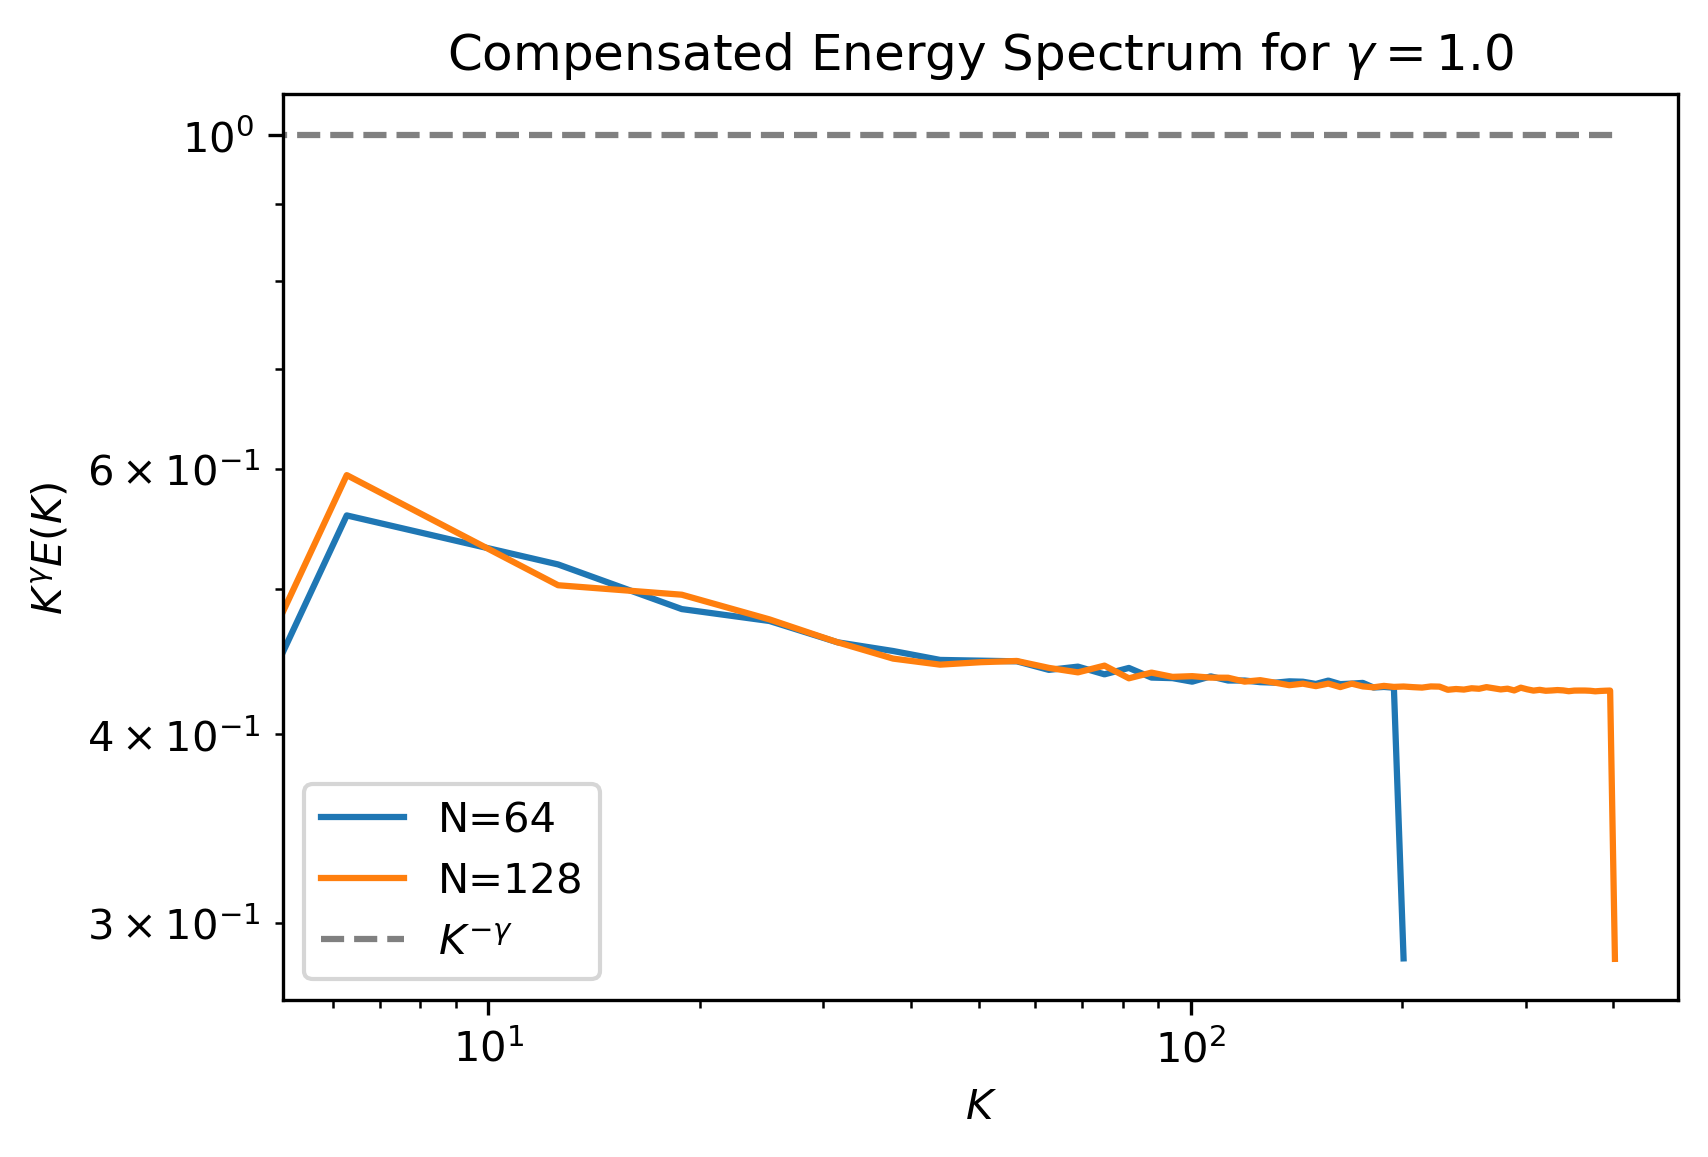

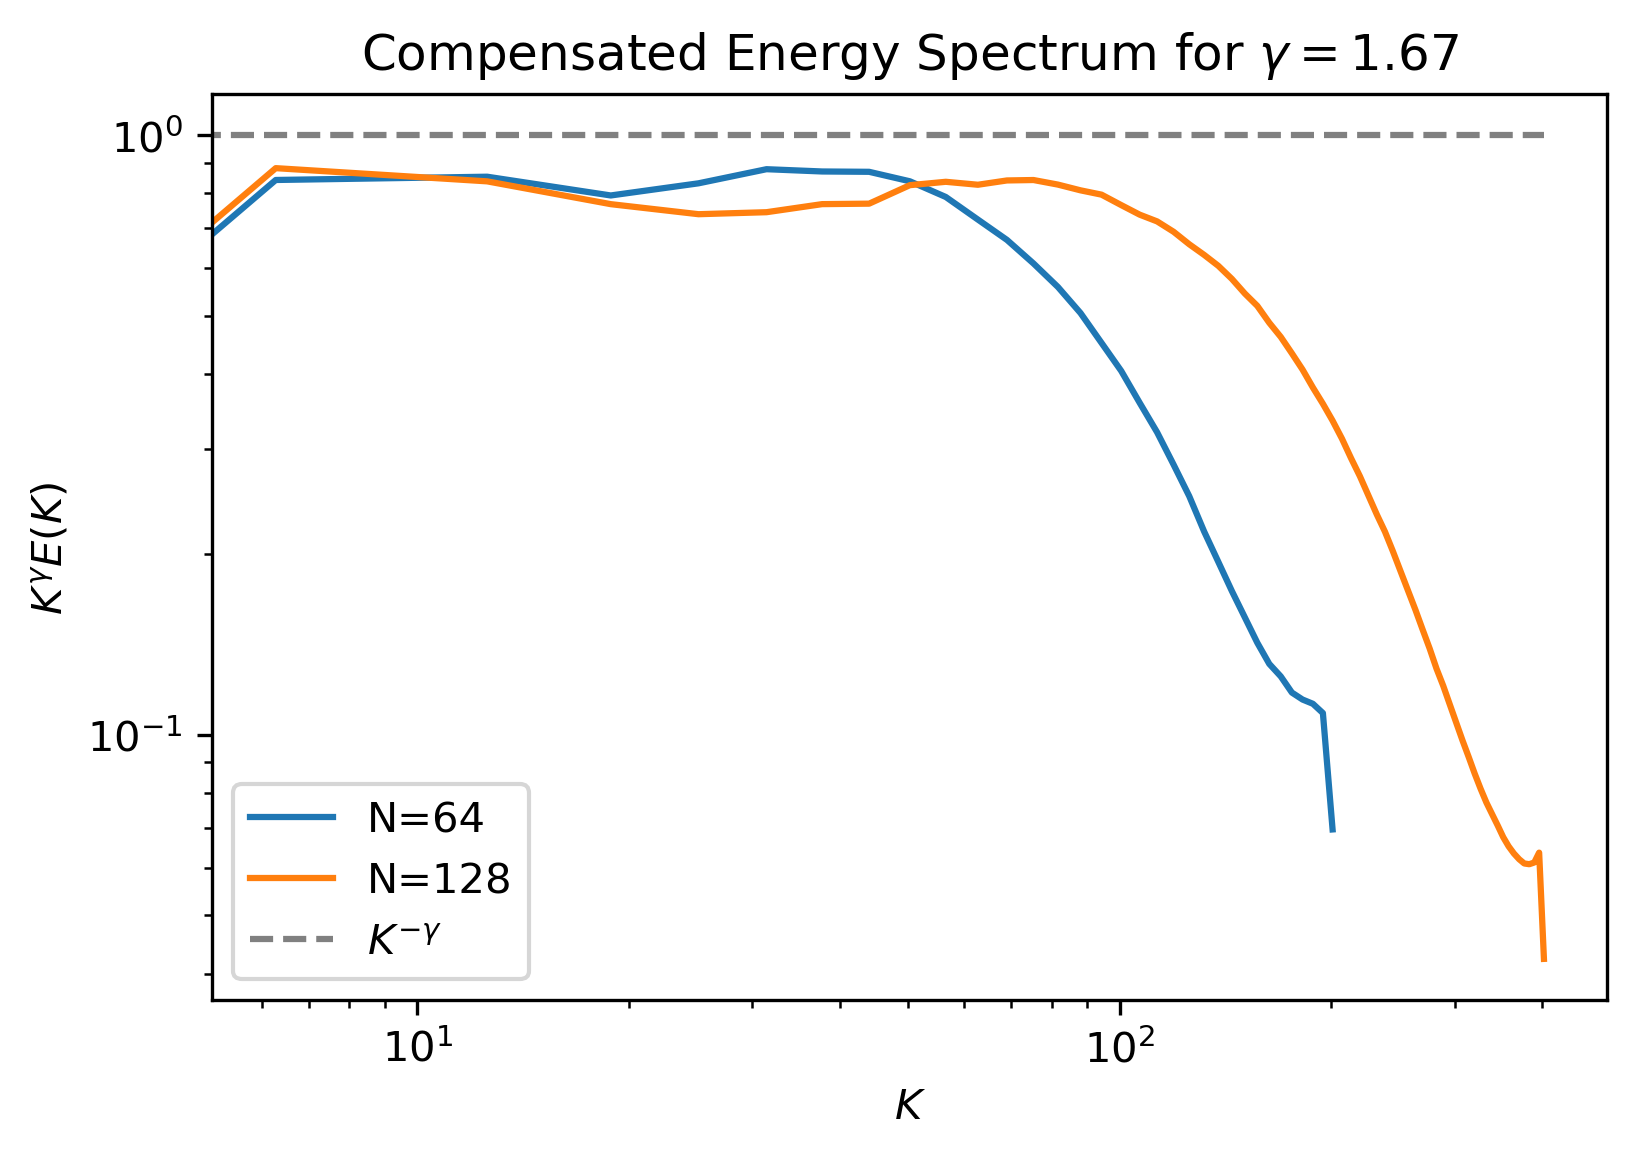

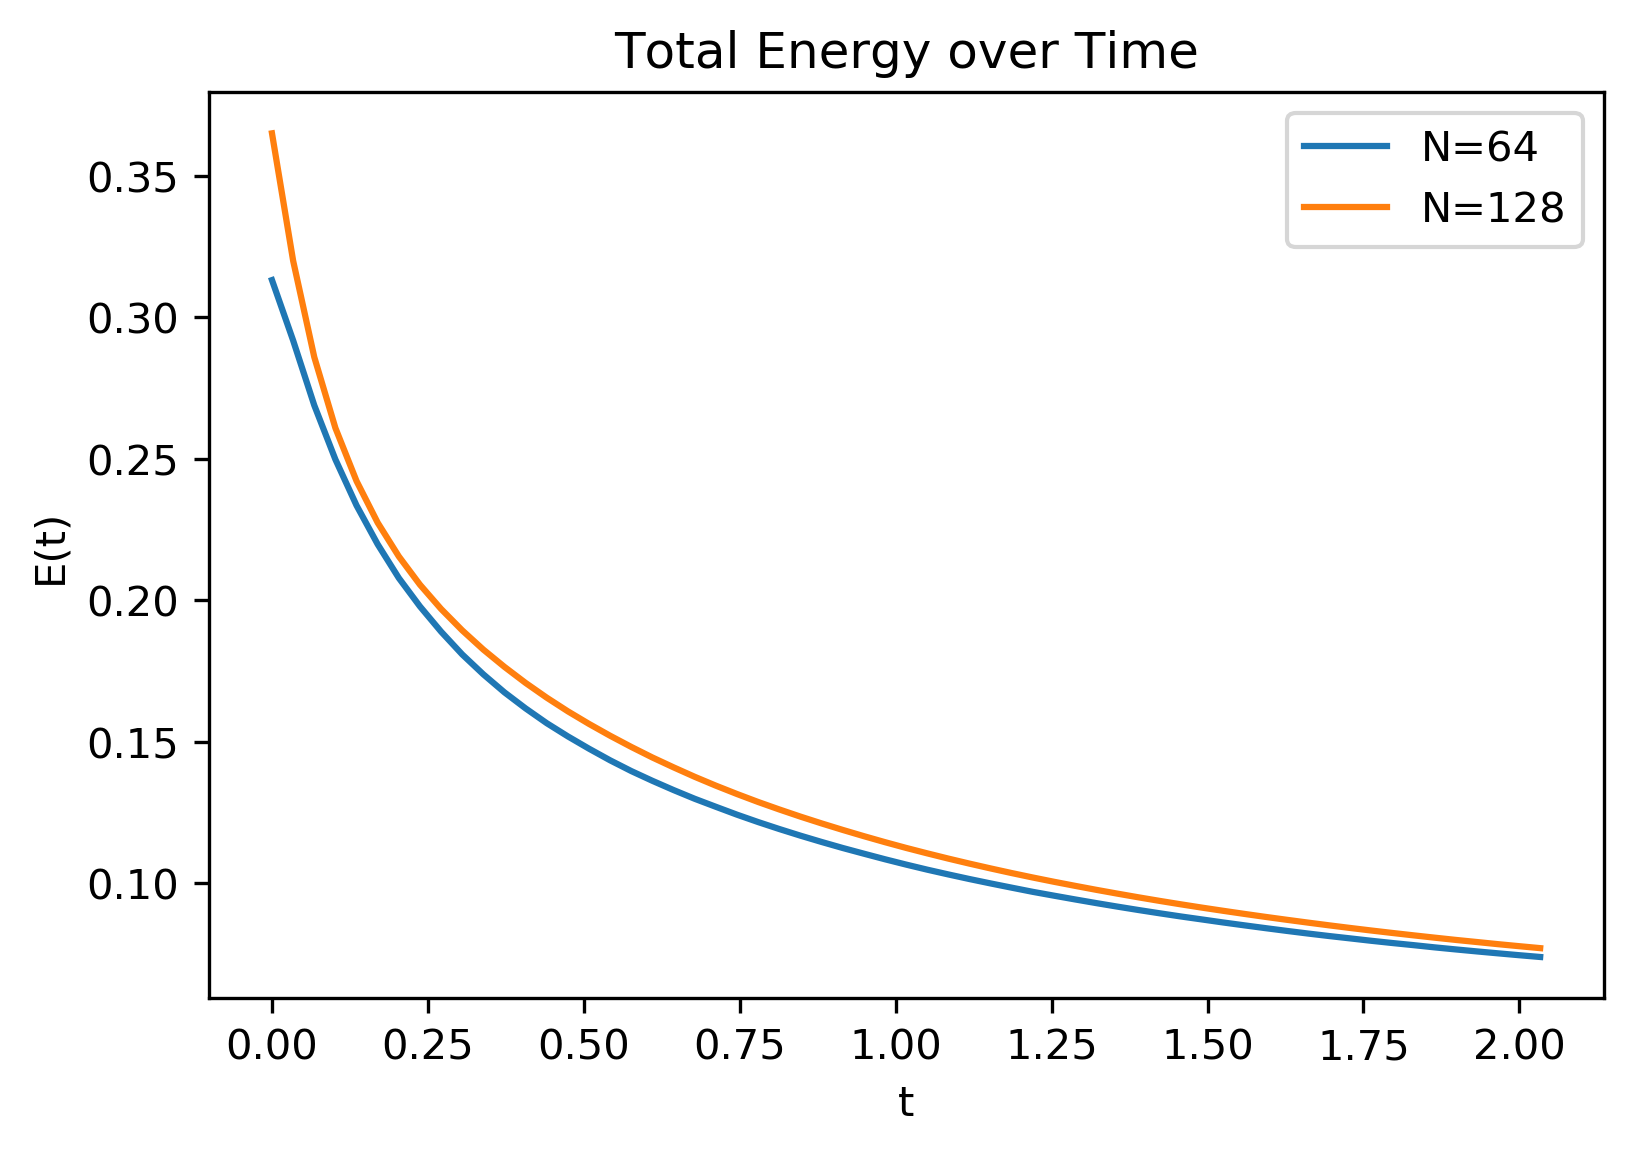

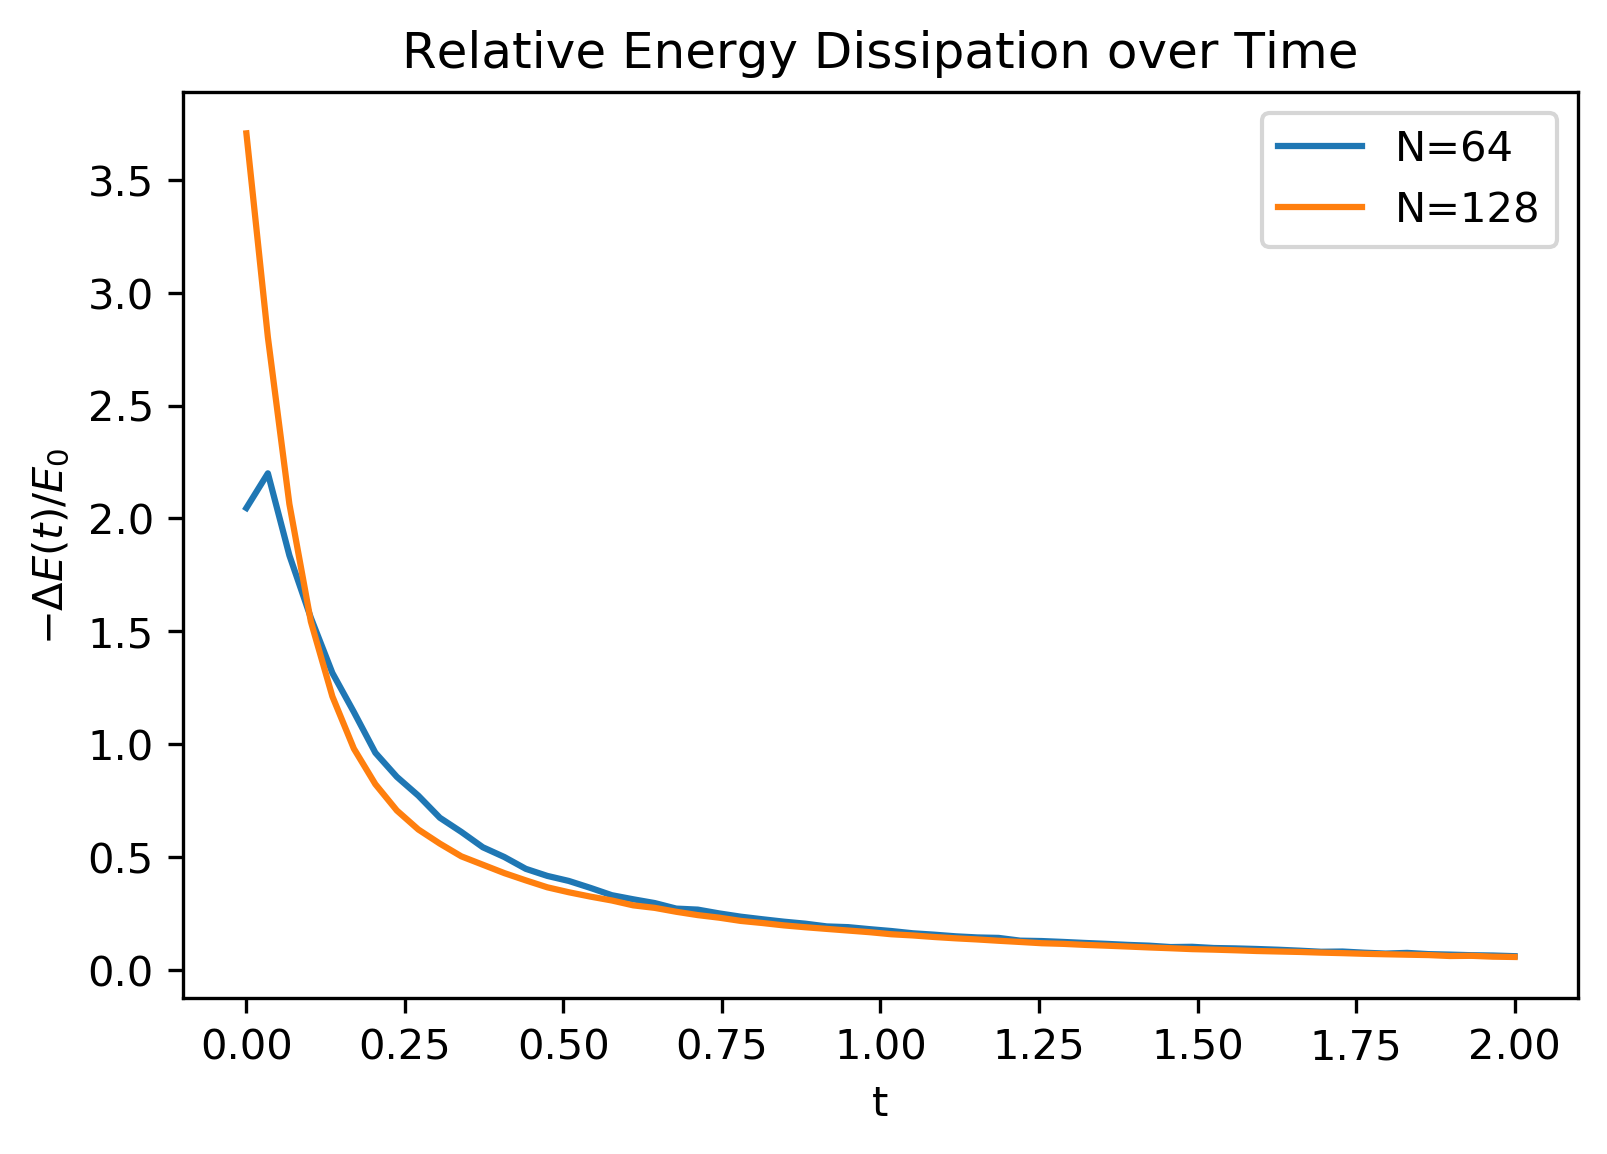

In [47]:
plot_spectrum(['/home/tobias/Programmieren/azeban/build/bm_N64',
               '/home/tobias/Programmieren/azeban/build/bm_N128'],
              [64, 128], 0, 1.)
plot_spectrum(['/home/tobias/Programmieren/azeban/build/bm_N64',
               '/home/tobias/Programmieren/azeban/build/bm_N128'],
              [64, 128], 60, 5/3)
plot_energy(['/home/tobias/Programmieren/azeban/build/bm_N64',
             '/home/tobias/Programmieren/azeban/build/bm_N128'],
            [64, 128], 2/60)
plot_relative_energy_dissipation(['/home/tobias/Programmieren/azeban/build/bm_N64',
                                  '/home/tobias/Programmieren/azeban/build/bm_N128'],
                                 [64, 128, 256], 2/60)

# Energy Spectra of Taylor Green

In [ ]:
plot_spectrum(['/home/tobias/Programmieren/azeban/build/tg_N64',
               '/home/tobias/Programmieren/azeban/build/tg_N128'],
              [64, 128], 0, 1.)
plot_spectrum(['/home/tobias/Programmieren/azeban/build/tg_N64',
               '/home/tobias/Programmieren/azeban/build/tg_N128'],
              [64, 128], 150, 5/3)
plot_energy(['/home/tobias/Programmieren/azeban/build/tg_N64',
             '/home/tobias/Programmieren/azeban/build/tg_N128'],
            [64, 128], 5/150)
plot_relative_energy_dissipation(['/home/tobias/Programmieren/azeban/build/tg_N64',
                                  '/home/tobias/Programmieren/azeban/build/tg_N128'],
                                 [64, 128, 256], 2/150)